In [5]:
import numpy as np

def euclidean_distance(x:np.array, y:np.array, return_squared:bool=False) -> float:
    """
    Compute the Euclidean distance between 2 arrays: x, y

    Args:
        x (np.array): First array
        y (np.array): Second array
        squared (bool, optional): Whether to return the squared form or not. Defaults to False.

    Returns:
        float: The computed Euclidean distance
    """
    if return_squared:
        return np.sum(np.square(x-y))
    return np.sqrt(np.sum(np.square(x-y)))

def compute_cost_matrix(X:np.ndarray, Y:np.ndarray, f:str='squared_euclidean') -> np.ndarray:
    """
    Compute the cost matrix between two time series.
    If they differ in lengths, the matrix will be m x n, otherwise n x n.
    The two time series must have the same number of features (predictors).

    Args:
        X (np.ndarray): First time series of the form time instants x features.
        Y (np.ndarray): Second time series of the form time instants x features.

    Returns:
        np.ndarray: The cost matrix
    """
    n = X.shape[0]
    m = Y.shape[0]
    C = np.zeros(shape=(n,m))
    
    for i in range(n):
        for j in range(m):
            
            if f == 'squared_euclidean':
                C[i,j] = euclidean_distance(X[i,:], Y[j,:], return_squared=True)
            elif f == 'absolute_difference':
                C[i,j] = np.abs(np.sum(X[i,:] - Y[j,:]))
    
    return C

Number of nodes: 12
[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]


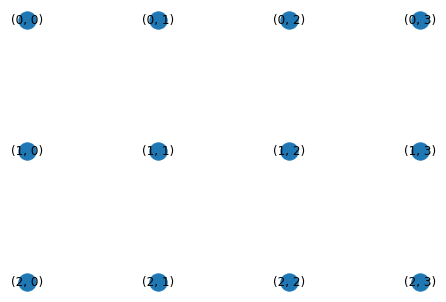

In [48]:
import networkx as nx
from typing import List, Tuple

def compute_dtw(X:np.ndarray,Y:np.ndarray, show_graph:bool=False) -> Tuple[float, List[Tuple]]:
    """
    It computes the DTW score between two multivariate time series X and Y
    of the form [time_instants, num_features]

    Args:
        X (np.ndarray): First time series
        Y (np.ndarray): Second time series
        show_graph (bool, optional): Whether to show the graph or not. Defaults to False, 
        since graphs are very large.

    Returns:
        Tuple[float, List[Tuple]]: DTW score, shortest path. The latter is the sequence of nodes
    """
    n = X.shape[0]
    m = Y.shape[0]
    G, cost_matrix = construct_graph(X,Y,draw=show_graph)
    sh_path = nx.shortest_path(G, source=(0,0), target=(n-1,m-1), weight='weight')
    DTW_score = cost_matrix[(0,0)] + nx.path_weight(G, sh_path, weight='weight')
    # print(f"The shortest path is {sh_path} with DTW score of {DTW_score}")
    return DTW_score, sh_path
    
def construct_graph(X:np.ndarray,Y:np.ndarray, allowed_transitions:List[Tuple]=[(0,1), (1,0), (1,1)], draw:bool=False) -> Tuple[nx.DiGraph, np.ndarray]:
    """
    It constructs the graph upon which we search the path with minimum weight.
    The graph is constructed in the form of the cost matrix C. This will be used to compute DTW score.
    Only allowed_transitions are considered. Hence there won't be all the feasible edges.
    Args:
        X (np.ndarray): First time series of the form [time_instants, num_predictors].
        Y (np.ndarray): Second time series of the form [time_instants, num_predictors].
        allowed_transitions (List[Tuple], optional): List of feasible edges. Defaults to [(0,1), (1,0), (1,1)] to compute DTW.
        draw (bool, optional): Whether to draw or not the graph. Defaults to False.

    Returns:
        Tuple[nx.DiGraph, np.ndarray]: The corresponding graph and the cost matrix.
        The latter has the form [time_instants_of_X, time_instants_of_Y]
    """
    
    n = X.shape[0]
    m = Y.shape[0]
    
    nodes = []
    for i in range(n):
        for j in range(m):
            nodes.append( (i,j) )
            
    edges = compute_allowed_edges(nodes, allowed_transitions)
    C = compute_cost_matrix(X, Y, f='squared_euclidean')
    weighted_edges = weight_edges(edges, C)
    
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_weighted_edges_from(weighted_edges)
    if draw:
        pos = {i:(i[1], -i[0]) for i in G.nodes}
        nx.draw(G, pos, with_labels=True)
    return G, C
    
from itertools import combinations
def compute_allowed_edges(nodes:List[Tuple], allowed_combinations:list=[(0,1), (1,0), (1,1)]) -> List[Tuple]:
    """
    Compute allowed edges from all possible combination of 2 nodes following the allowed set of combinations.

    Args:
        nodes (List[Tuple]): List of nodes from which we compute all possible combinations.
        allowed_combinations (list, optional): Set of allowed transitions. Defaults to [(0,1), (1,0), (1,1)].

    Returns:
        List[Tuple]: List of edges following the allowed_combinations list.
    """
    combs = list(combinations(nodes, 2))

    allowed_edges = []
    illegal_edges = []

    for combination in combs:
        c0 = combination[0]
        c1 = combination[1]
        res = (c1[0]-c0[0], c1[1]-c0[1])
        if res in allowed_combinations:
            allowed_edges.append(combination)
        else:
            illegal_edges.append(combination)
    return allowed_edges

def weight_edges(edges:List[Tuple], cost_matrix:np.ndarray) -> List[Tuple]:
    """
    Weight each edge with the corresponding transition cost from one node to another

    Args:
        edges (List[Tuple]): Set of edges.
        cost_matrix (np.ndarray): Cost matrix C

    Returns:
        List[Tuple]: Return the set of edges with the new attribute 'weight'
    """
    weighted_edges = []
    for i in edges:
        s = i[0] # source node
        t = i[1] # target node
        weighted_edges.append( (*i, cost_matrix[t]) )
    return weighted_edges




n = 3
m = 4

nodes = []
for i in range(n):
    for j in range(m):
        nodes.append( (i,j) )
G = nx.DiGraph()
G.add_nodes_from(nodes)

n_nodes = len(G)
print("Number of nodes:", n_nodes)

# labels of nodes are couples: (row, column)

print(G.nodes)
pos = {i:(i[1], -i[0]) for i in G.nodes}
nx.draw(G, pos, with_labels=True)

In [10]:
from itertools import combinations

combs = list(combinations(nodes, 2))

allowed_combinations = [(0,1), (1,0), (1,1)]

allowed_edges = []
illegal_edges = []

for combination in combs:
    c0 = combination[0]
    c1 = combination[1]
    res = (c1[0]-c0[0], c1[1]-c0[1])
    if res in allowed_combinations:
        allowed_edges.append(combination)
    else:
        illegal_edges.append(combination)


In [11]:
X = np.array([[0,1,2,3], [4,5,6,7], [8,9,10,11]])
Y = np.array([[0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15]])
C = compute_cost_matrix(X, Y, f='squared_euclidean')
print(allowed_edges[2])
s = allowed_edges[2][0]
t = allowed_edges[2][1]
C[t]

((0, 0), (1, 1))


0.0

In [12]:
C

array([[  0.,  64., 256., 576.],
       [ 64.,   0.,  64., 256.],
       [256.,  64.,   0.,  64.]])

In [13]:
weighted_edges = []
for i in allowed_edges:
    s = i[0]
    t = i[1]
    weighted_edges.append( (*i, C[t]) )
#[(i, {'weight':C[i[-1]]}) for i in allowed_edges]

[((0, 0), (0, 1)),
 ((0, 0), (1, 0)),
 ((0, 0), (1, 1)),
 ((0, 1), (0, 2)),
 ((0, 1), (1, 1)),
 ((0, 1), (1, 2)),
 ((0, 2), (0, 3)),
 ((0, 2), (1, 2)),
 ((0, 2), (1, 3)),
 ((0, 3), (1, 3)),
 ((1, 0), (1, 1)),
 ((1, 0), (2, 0)),
 ((1, 0), (2, 1)),
 ((1, 1), (1, 2)),
 ((1, 1), (2, 1)),
 ((1, 1), (2, 2)),
 ((1, 2), (1, 3)),
 ((1, 2), (2, 2)),
 ((1, 2), (2, 3)),
 ((1, 3), (2, 3)),
 ((2, 0), (2, 1)),
 ((2, 1), (2, 2)),
 ((2, 2), (2, 3))]

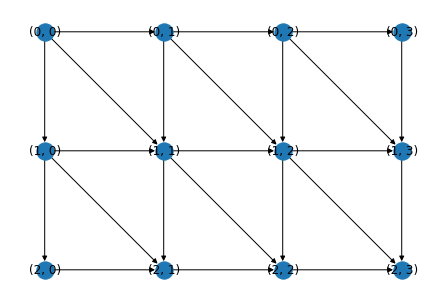

In [14]:
G.add_weighted_edges_from(weighted_edges)
nx.draw(G, pos, with_labels=True)
list(G.edges)

In [15]:
sh_path = nx.shortest_path(G, source=(0,0), target=(n-1,m-1), weight='weight')
DTW_score = C[(0,0)] + nx.path_weight(G, sh_path, weight='weight')
print(f"The shortest path is {sh_path} with DTW score of {DTW_score}")

The shortest path is [(0, 0), (1, 1), (2, 2), (2, 3)] with DTW score of 64.0


In [153]:
C[0][0]

0.0

In [8]:
X = np.array([[0,1,2,3], [4,5,6,7], [8,9,10,11]])
Y = np.array([[0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15]])
compute_dtw(X,Y)

The shortest path is [(0, 0), (1, 1), (2, 2), (2, 3)] with DTW score of 64.0


--------------------
StackOverflow distance

In [2]:
from scipy.spatial import distance
#custom metric
def DTW(a, b):   
    an = a.shape[0]
    bn = b.shape[0]
    
    pointwise_distance = distance.cdist(a,b, metric='sqeuclidean')
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

------------

## Experiments

In [7]:
original_list = list(range(4))
x = np.array(original_list)
y = np.array([i*3 for i in original_list])
euclidean_distance(x,y,True)

56

In [63]:
X = np.array([[0,1,2,3], [4,5,6,7], [8,9,10,11]])
Y = np.array([[0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15]])
C = compute_cost_matrix(X, Y)
C

array([[  0.,  64., 256., 576.],
       [ 64.,   0.,  64., 256.],
       [256.,  64.,   0.,  64.]])

In [13]:
euclidean_distance(np.array([0,1,2,3]), np.array([8,9,10,11]), True)

256

In [67]:
X = np.array([[0,1,2,3], [4,5,6,7], [8,9,10,11]])
Y = np.array([[0,1,2,3], [4,5,6,7], [8,9,10,11], [12,13,14,15]])
C = compute_cost_matrix(X, Y)
print(allowed_edges[2])
s = allowed_edges[2][0]
t = allowed_edges[2][1]
C[t]

((0, 0), (1, 1))


0.0

# KNNeighbors

In [1]:
import pandas as pd
import numpy as np
import os
import utils
import classes

In [2]:
features_1 = [
    'sx_x',
    'sx_y',
    'sx_z',
    'sx_roll',
    'sx_pitch',
    'sx_yaw',
    'sx_thumb',
    'sx_forefinger',
    'sx_middle_finger',
    'sx_ring_finger',
    'sx_little_finger',
    'dx_x',
    'dx_y',
    'dx_z',
    'dx_roll',
    'dx_pitch',
    'dx_yaw',
    'dx_thumb',
    'dx_forefinger',
    'dx_middle_finger',
    'dx_ring_finger',
    'dx_little_finger'
    ]



In [3]:
path = "./tctodd/"
#path = "../../Desktop/MML Project/tctodd/"
dirs = os.listdir(path=path)
weeks = sorted([i for i in dirs if i != ".DS_Store"])
filenames = sorted(os.listdir(path+weeks[1]))

data = []
labels = dict()
label_cnt = 0

for w in weeks:
    temp_path = path+w+"/"
    filenames = sorted(os.listdir(temp_path))
    for fn in filenames:
        label = fn.split('.')[0][:-2]
        
        if label not in labels:
            labels[label] = label_cnt
            label_cnt += 1
            
        data.append({'label':labels[label], 'time_series':pd.read_csv(temp_path+fn, header=None, sep='\t',).values})
        

In [4]:
df = pd.DataFrame(data, columns=['label', 'time_series'])
seed = 0
X = df['time_series']
y = df['label']

In [5]:
longest_series_shape = sorted(X.apply(lambda x: x.shape), key=lambda a: -a[0])[0]
longest_series_shape

(136, 22)

In [6]:
'''from typing import Tuple

def fill_nan_return_array(longest_series_shape:Tuple, time_series:pd.Series):
    new_series = np.full(longest_series_shape, 10000, dtype='float64')
    new_series.ravel()[:time_series.size] = time_series.ravel()
    return new_series.reshape(-1)'''


"from typing import Tuple\n\ndef fill_nan_return_array(longest_series_shape:Tuple, time_series:pd.Series):\n    new_series = np.full(longest_series_shape, 10000, dtype='float64')\n    new_series.ravel()[:time_series.size] = time_series.ravel()\n    return new_series.reshape(-1)"

In [7]:
new_X = X.apply(lambda x: utils.fill_nan_return_array(longest_series_shape, x))
new_X.apply(lambda x: x.shape).value_counts()

(2992,)    2565
Name: time_series, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


'''d = dict()


for id in range(len(X)):
    l = []
    for i in range(X.iloc[id].shape[-1]):
        l.append(pd.Series(X.iloc[id][:,i]))
    d[id] = l

X_df = pd.DataFrame.from_dict(d, orient='index', columns=features_1)

'''
X_train, X_test, y_train, y_test = train_test_split(new_X, y,
                                                    stratify=y, 
                                                    test_size=0.1, random_state=seed)

In [9]:
train_list = np.array([i for i in X_train])
test_list = np.array([i for i in X_test])


In [10]:
train_list[0]

array([    0,     0,     0, ..., 10000, 10000, 10000])

In [136]:
def restore_time_series(X:np.array, flag_value:int=10000) -> np.array:
    """
    Restore the time series

    Args:
        X (np.array): _description_
        flag_value (int, optional): _description_. Defaults to 10000.

    Returns:
        np.array: _description_
    """
    idx = -1
    for i in range(len(X)):
        if X[i] == flag_value:
            idx = i
            break
    if idx == -1:
        return X.reshape((-1,22))    
    
    return X[:idx].reshape((-1,22))

# DTW stack overflow/wikipedia
from scipy.spatial import distance
#custom metric
def DTW(a, b):
    
    new_a = restore_time_series(a)
    new_b = restore_time_series(b)
    
    an = new_a.shape[0]
    bn = new_b.shape[0]
    
    pointwise_distance = distance.cdist(new_a, new_b, metric='sqeuclidean')
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

In [11]:
knn = KNeighborsClassifier(n_neighbors=1, metric=utils.DTW)

knn.fit(train_list, y_train)

preds = knn.predict(test_list)

score = accuracy_score(y_test, preds)
print(score)

0.1245136186770428
